In [14]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [3]:
class ABENet(nn.Module):
    def __init__(self, N, nkeys=1):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=(nkeys+1)*N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

![asymmetric_encryption](img/asymmetric_enc.png)

In [15]:
N = 16 # [16, 32, 64]
minibatch_size = 4096 # [256..4096]
A = ABENet(N, nkeys=1).to(DEVICE)   # Alice (encrypts with Public key)
B = ABENet(N, nkeys=2).to(DEVICE)   # Bob   (decrypts with Private key)
E = ABENet(N, nkeys=1).to(DEVICE)   # Eve
PG = ABENet(N, nkeys=0).to(DEVICE)   # Public key generator (every party has pub-key)

A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
E_optimizer = optim.Adam(E.parameters(), lr=0.0008)
PG_optimizer = optim.Adam(E.parameters(), lr=0.0008)

l1_norm = nn.L1Loss()
loss_bob, loss_eve = l1_norm, l1_norm
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))

max_iter = 150000
ABs = []
Es = []

A.train()
B.train()
E.train()
PG.train()

start_time = time.time()
for ic in range(max_iter):
    for who, num_minibatches in [('AB', 1), ('E', 2)]:
        for _ in range(num_minibatches):
            P = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            K = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            
            PK    = PG(K)
            C     = A(torch.cat((P, PK), dim=1))
            P_bob = B(torch.cat((C, PK, K), dim=1))
            P_eve = E(torch.cat((C, PK), dim=1))

            if who == 'AB':
                AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                A_optimizer.zero_grad()
                B_optimizer.zero_grad()
                PG_optimizer.zero_grad()
                AB_loss.backward()
                A_optimizer.step()
                B_optimizer.step()
                PG_optimizer.step()
                
            elif who == 'E':
                E_loss  = loss_eve(P_eve, P)

                E_optimizer.zero_grad()
                E_loss.backward()
                E_optimizer.step()

    if ic % 1000 == 999:
        elapsed_time = time.time() - start_time
        print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
            ic+1, AB_loss, E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    ABs.append(AB_loss.item())
    Es.append(E_loss.item())
    if AB_loss < 0.005 and E_loss > 0.5: # AB_loss < 0.05 and E_loss > 2
        break


[  1000] AB_loss: 1.0002 E_loss: 1.0001 Elapsed Time: 00:00:46


[  2000] AB_loss: 1.0000 E_loss: 1.0000 Elapsed Time: 00:01:32


[  3000] AB_loss: 0.0692 E_loss: 0.8998 Elapsed Time: 00:02:43


[  4000] AB_loss: 0.0634 E_loss: 0.8291 Elapsed Time: 00:03:57


[  5000] AB_loss: 0.0793 E_loss: 0.7883 Elapsed Time: 00:05:11


[  6000] AB_loss: 0.1329 E_loss: 0.6950 Elapsed Time: 00:06:26


[  7000] AB_loss: 0.1923 E_loss: 0.6593 Elapsed Time: 00:07:40


[  8000] AB_loss: 0.1704 E_loss: 0.6858 Elapsed Time: 00:08:55


[  9000] AB_loss: 0.1388 E_loss: 0.6691 Elapsed Time: 00:10:09


[ 10000] AB_loss: 0.2314 E_loss: 0.5667 Elapsed Time: 00:11:24


[ 11000] AB_loss: 0.3037 E_loss: 0.5171 Elapsed Time: 00:12:38


[ 12000] AB_loss: 0.2132 E_loss: 0.5936 Elapsed Time: 00:13:53


[ 13000] AB_loss: 0.2094 E_loss: 0.5909 Elapsed Time: 00:15:07


[ 14000] AB_loss: 0.3030 E_loss: 0.5536 Elapsed Time: 00:16:22


[ 15000] AB_loss: 0.2676 E_loss: 0.5952 Elapsed Time: 00:17:36


[ 16000] AB_loss: 0.2932 E_loss: 0.5499 Elapsed Time: 00:18:51


[ 17000] AB_loss: 0.2203 E_loss: 0.6220 Elapsed Time: 00:20:05


[ 18000] AB_loss: 0.2521 E_loss: 0.5949 Elapsed Time: 00:21:20


[ 19000] AB_loss: 0.3021 E_loss: 0.5403 Elapsed Time: 00:22:34


[ 20000] AB_loss: 0.2932 E_loss: 0.5203 Elapsed Time: 00:23:48


[ 21000] AB_loss: 0.2995 E_loss: 0.5373 Elapsed Time: 00:25:03


[ 22000] AB_loss: 0.2684 E_loss: 0.6106 Elapsed Time: 00:26:17


[ 23000] AB_loss: 0.3023 E_loss: 0.6157 Elapsed Time: 00:27:32


[ 24000] AB_loss: 0.3666 E_loss: 0.5383 Elapsed Time: 00:28:46


[ 25000] AB_loss: 0.2996 E_loss: 0.6103 Elapsed Time: 00:30:01


[ 26000] AB_loss: 0.3379 E_loss: 0.5946 Elapsed Time: 00:31:15


[ 27000] AB_loss: 0.3910 E_loss: 0.5577 Elapsed Time: 00:32:30


[ 28000] AB_loss: 0.3897 E_loss: 0.5636 Elapsed Time: 00:33:44


[ 29000] AB_loss: 0.3775 E_loss: 0.5518 Elapsed Time: 00:34:59


[ 30000] AB_loss: 0.4579 E_loss: 0.5429 Elapsed Time: 00:36:14


[ 31000] AB_loss: 0.4574 E_loss: 0.5098 Elapsed Time: 00:37:28


[ 32000] AB_loss: 0.4863 E_loss: 0.4777 Elapsed Time: 00:38:42


[ 33000] AB_loss: 0.5249 E_loss: 0.4547 Elapsed Time: 00:39:57


[ 34000] AB_loss: 0.4919 E_loss: 0.5485 Elapsed Time: 00:41:11


[ 35000] AB_loss: 0.4997 E_loss: 0.5500 Elapsed Time: 00:42:21


[ 36000] AB_loss: 0.4736 E_loss: 0.5540 Elapsed Time: 00:43:07


[ 37000] AB_loss: 0.4621 E_loss: 0.5690 Elapsed Time: 00:43:53


[ 38000] AB_loss: 0.5278 E_loss: 0.5289 Elapsed Time: 00:44:39


[ 39000] AB_loss: 0.5613 E_loss: 0.5111 Elapsed Time: 00:45:25


[ 40000] AB_loss: 0.5721 E_loss: 0.5061 Elapsed Time: 00:46:11


[ 41000] AB_loss: 0.5493 E_loss: 0.5313 Elapsed Time: 00:46:57


[ 42000] AB_loss: 0.4941 E_loss: 0.5297 Elapsed Time: 00:47:43


[ 43000] AB_loss: 0.5201 E_loss: 0.4922 Elapsed Time: 00:48:29


[ 44000] AB_loss: 0.5175 E_loss: 0.4811 Elapsed Time: 00:49:15


[ 45000] AB_loss: 0.5571 E_loss: 0.4513 Elapsed Time: 00:50:01


[ 46000] AB_loss: 0.5381 E_loss: 0.4659 Elapsed Time: 00:50:48


[ 47000] AB_loss: 0.4965 E_loss: 0.4946 Elapsed Time: 00:51:34


[ 48000] AB_loss: 0.4306 E_loss: 0.5608 Elapsed Time: 00:52:20


[ 49000] AB_loss: 0.3968 E_loss: 0.5621 Elapsed Time: 00:53:06


[ 50000] AB_loss: 0.4068 E_loss: 0.5606 Elapsed Time: 00:53:52


[ 51000] AB_loss: 0.4191 E_loss: 0.5603 Elapsed Time: 00:54:38


[ 52000] AB_loss: 0.3874 E_loss: 0.5748 Elapsed Time: 00:56:04


[ 53000] AB_loss: 0.3023 E_loss: 0.6164 Elapsed Time: 00:57:30


[ 54000] AB_loss: 0.3426 E_loss: 0.5687 Elapsed Time: 00:58:57


[ 55000] AB_loss: 0.3304 E_loss: 0.5940 Elapsed Time: 01:00:23


[ 56000] AB_loss: 0.3688 E_loss: 0.5622 Elapsed Time: 01:01:50


[ 57000] AB_loss: 0.3421 E_loss: 0.5813 Elapsed Time: 01:03:04


[ 58000] AB_loss: 0.3656 E_loss: 0.5584 Elapsed Time: 01:03:50


[ 59000] AB_loss: 0.4145 E_loss: 0.5221 Elapsed Time: 01:04:36


[ 60000] AB_loss: 0.3626 E_loss: 0.5595 Elapsed Time: 01:05:22


[ 61000] AB_loss: 0.3348 E_loss: 0.5714 Elapsed Time: 01:06:08


[ 62000] AB_loss: 0.3757 E_loss: 0.5360 Elapsed Time: 01:06:54


[ 63000] AB_loss: 0.3771 E_loss: 0.5391 Elapsed Time: 01:07:40


[ 64000] AB_loss: 0.3858 E_loss: 0.5436 Elapsed Time: 01:08:26


[ 65000] AB_loss: 0.3792 E_loss: 0.5349 Elapsed Time: 01:09:30


[ 66000] AB_loss: 0.3921 E_loss: 0.5164 Elapsed Time: 01:10:56


[ 67000] AB_loss: 0.3709 E_loss: 0.5447 Elapsed Time: 01:12:22


[ 68000] AB_loss: 0.3196 E_loss: 0.5948 Elapsed Time: 01:13:49


[ 69000] AB_loss: 0.3653 E_loss: 0.5359 Elapsed Time: 01:15:15


[ 70000] AB_loss: 0.3895 E_loss: 0.5033 Elapsed Time: 01:16:34


[ 71000] AB_loss: 0.3439 E_loss: 0.5700 Elapsed Time: 01:17:21


[ 72000] AB_loss: 0.3434 E_loss: 0.5716 Elapsed Time: 01:18:07


[ 73000] AB_loss: 0.3243 E_loss: 0.6105 Elapsed Time: 01:18:53


[ 74000] AB_loss: 0.3359 E_loss: 0.5822 Elapsed Time: 01:19:42


[ 75000] AB_loss: 0.3311 E_loss: 0.5905 Elapsed Time: 01:20:37


[ 76000] AB_loss: 0.3480 E_loss: 0.5679 Elapsed Time: 01:21:32


[ 77000] AB_loss: 0.3268 E_loss: 0.5846 Elapsed Time: 01:22:23


[ 78000] AB_loss: 0.3109 E_loss: 0.5935 Elapsed Time: 01:23:28


[ 79000] AB_loss: 0.3081 E_loss: 0.6034 Elapsed Time: 01:24:51


[ 80000] AB_loss: 0.3109 E_loss: 0.6199 Elapsed Time: 01:26:02


[ 81000] AB_loss: 0.3129 E_loss: 0.5926 Elapsed Time: 01:27:16


[ 82000] AB_loss: 0.3260 E_loss: 0.5755 Elapsed Time: 01:28:38


[ 83000] AB_loss: 0.3040 E_loss: 0.5910 Elapsed Time: 01:30:01


[ 84000] AB_loss: 0.3224 E_loss: 0.5961 Elapsed Time: 01:31:24


[ 85000] AB_loss: 0.3087 E_loss: 0.5924 Elapsed Time: 01:32:47


[ 86000] AB_loss: 0.3841 E_loss: 0.5218 Elapsed Time: 01:34:10


[ 87000] AB_loss: 0.3495 E_loss: 0.5693 Elapsed Time: 01:35:33


[ 88000] AB_loss: 0.4023 E_loss: 0.5120 Elapsed Time: 01:36:56


[ 89000] AB_loss: 0.3020 E_loss: 0.5845 Elapsed Time: 01:38:19


[ 90000] AB_loss: 0.3549 E_loss: 0.5701 Elapsed Time: 01:39:42


[ 91000] AB_loss: 0.2824 E_loss: 0.5985 Elapsed Time: 01:41:05


[ 92000] AB_loss: 0.2789 E_loss: 0.5746 Elapsed Time: 01:42:28


[ 93000] AB_loss: 0.2906 E_loss: 0.5780 Elapsed Time: 01:43:51


[ 94000] AB_loss: 0.2656 E_loss: 0.5801 Elapsed Time: 01:44:50


[ 95000] AB_loss: 0.2471 E_loss: 0.6080 Elapsed Time: 01:45:36


[ 96000] AB_loss: 0.2737 E_loss: 0.5579 Elapsed Time: 01:46:22


[ 97000] AB_loss: 0.2602 E_loss: 0.5999 Elapsed Time: 01:47:08


[ 98000] AB_loss: 0.2859 E_loss: 0.5627 Elapsed Time: 01:47:55


[ 99000] AB_loss: 0.2959 E_loss: 0.5713 Elapsed Time: 01:48:41


[100000] AB_loss: 0.2768 E_loss: 0.5905 Elapsed Time: 01:49:27


[101000] AB_loss: 0.2165 E_loss: 0.6625 Elapsed Time: 01:50:13


[102000] AB_loss: 0.2141 E_loss: 0.6519 Elapsed Time: 01:50:59


[103000] AB_loss: 0.2349 E_loss: 0.6322 Elapsed Time: 01:51:46


[104000] AB_loss: 0.2331 E_loss: 0.6282 Elapsed Time: 01:52:32


[105000] AB_loss: 0.2477 E_loss: 0.6233 Elapsed Time: 01:53:18


[106000] AB_loss: 0.2340 E_loss: 0.6225 Elapsed Time: 01:54:05


[107000] AB_loss: 0.2690 E_loss: 0.5855 Elapsed Time: 01:54:51


[108000] AB_loss: 0.2328 E_loss: 0.6326 Elapsed Time: 01:55:37


[109000] AB_loss: 0.2260 E_loss: 0.6311 Elapsed Time: 01:56:23


[110000] AB_loss: 0.2155 E_loss: 0.6283 Elapsed Time: 01:57:09


[111000] AB_loss: 0.2923 E_loss: 0.5705 Elapsed Time: 01:57:55


[112000] AB_loss: 0.2335 E_loss: 0.6123 Elapsed Time: 01:59:10


[113000] AB_loss: 0.2577 E_loss: 0.5947 Elapsed Time: 02:00:37


[114000] AB_loss: 0.2628 E_loss: 0.5802 Elapsed Time: 02:02:04


[115000] AB_loss: 0.2353 E_loss: 0.6345 Elapsed Time: 02:03:31


[116000] AB_loss: 0.2163 E_loss: 0.6374 Elapsed Time: 02:04:57


[117000] AB_loss: 0.2224 E_loss: 0.6177 Elapsed Time: 02:06:22


[118000] AB_loss: 0.2081 E_loss: 0.6358 Elapsed Time: 02:07:45


[119000] AB_loss: 0.1936 E_loss: 0.6640 Elapsed Time: 02:09:07


[120000] AB_loss: 0.2035 E_loss: 0.6676 Elapsed Time: 02:10:32


[121000] AB_loss: 0.2209 E_loss: 0.6418 Elapsed Time: 02:11:58


[122000] AB_loss: 0.2149 E_loss: 0.6670 Elapsed Time: 02:13:25


[123000] AB_loss: 0.2078 E_loss: 0.6503 Elapsed Time: 02:14:51


[124000] AB_loss: 0.2142 E_loss: 0.6440 Elapsed Time: 02:16:18


[125000] AB_loss: 0.1678 E_loss: 0.6790 Elapsed Time: 02:17:44


[126000] AB_loss: 0.1885 E_loss: 0.6524 Elapsed Time: 02:19:11


[127000] AB_loss: 0.2193 E_loss: 0.6365 Elapsed Time: 02:20:37


[128000] AB_loss: 0.2559 E_loss: 0.5816 Elapsed Time: 02:22:04


[129000] AB_loss: 0.1802 E_loss: 0.6125 Elapsed Time: 02:23:30


[130000] AB_loss: 0.1771 E_loss: 0.6251 Elapsed Time: 02:24:57


[131000] AB_loss: 0.1963 E_loss: 0.5978 Elapsed Time: 02:26:20


[132000] AB_loss: 0.1961 E_loss: 0.5883 Elapsed Time: 02:27:43


[133000] AB_loss: 0.2766 E_loss: 0.5182 Elapsed Time: 02:29:05


[134000] AB_loss: 0.2217 E_loss: 0.5587 Elapsed Time: 02:30:28


[135000] AB_loss: 0.2628 E_loss: 0.5298 Elapsed Time: 02:31:51


[136000] AB_loss: 0.2478 E_loss: 0.5433 Elapsed Time: 02:33:14


[137000] AB_loss: 0.2781 E_loss: 0.5240 Elapsed Time: 02:34:36


[138000] AB_loss: 0.2050 E_loss: 0.6137 Elapsed Time: 02:35:59


[139000] AB_loss: 0.2000 E_loss: 0.6185 Elapsed Time: 02:37:22


[140000] AB_loss: 0.2360 E_loss: 0.5837 Elapsed Time: 02:38:45


[141000] AB_loss: 0.2498 E_loss: 0.5821 Elapsed Time: 02:40:08


[142000] AB_loss: 0.2421 E_loss: 0.5760 Elapsed Time: 02:41:31


[143000] AB_loss: 0.2191 E_loss: 0.6018 Elapsed Time: 02:42:54


[144000] AB_loss: 0.2369 E_loss: 0.6050 Elapsed Time: 02:44:03


[145000] AB_loss: 0.2074 E_loss: 0.5975 Elapsed Time: 02:45:30


[146000] AB_loss: 0.1798 E_loss: 0.6276 Elapsed Time: 02:46:57


[147000] AB_loss: 0.1909 E_loss: 0.6299 Elapsed Time: 02:48:24


[148000] AB_loss: 0.1784 E_loss: 0.6411 Elapsed Time: 02:49:50


[149000] AB_loss: 0.1906 E_loss: 0.6235 Elapsed Time: 02:51:17


[150000] AB_loss: 0.1734 E_loss: 0.6624 Elapsed Time: 02:52:44


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


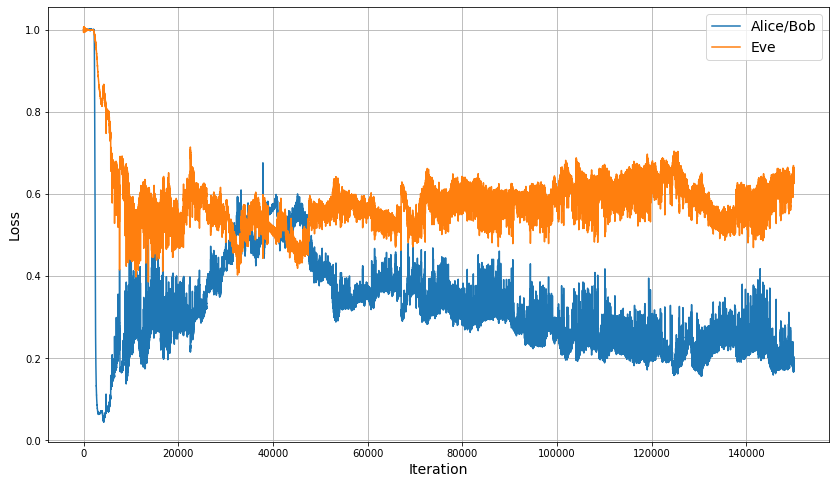

In [16]:
plt.figure(figsize=(14,8))
plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
plt.plot(range(1, len(Es)+1), Es, label='Eve')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both')
plt.show()